In [1]:
# cluster_reader.ipynb
# Authors: Stephan Meighen-Berger
# Loads and analyzes the results from dm_source_batch.py

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar

In [3]:
# picture path
PICS = '../pics/'

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [5]:
# Plotting standards
std_size = 3.
fontsize = 10.
lw=1.
h_length=1.
mark_s = 10
export_dpi = 200
# params
mag_fit = 1.
colors = ['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000']
alphas = [0.2, 0.4, 0.6, 0.8, 1.]
# labels_mass = ['1\;TeV', '100\;TeV', '10\;PeV', '30\;TeV']
linest = ['-', '--', '-.', ':']

In [6]:
# Run parameters
m_eborders = np.logspace(4., 8., 41)
m_ewidths = np.diff(m_eborders)
m_egrid = np.sqrt(m_eborders[1:]*m_eborders[:-1])
minimal_resolution = 0.2
ra_grid = np.arange(0., 360., minimal_resolution)
decl_grid = np.arange(0., 10., minimal_resolution)
flux_scan = np.logspace(-40, -10, 100)  # Fluxes to test
ide_scan = [0, 5, 10, 15, 18, 20, 25, 30, 35, 39]  # energy ids to test

In [7]:
pop_store = []
set_list = [1, 10, 100, 1000]
for set_id in set_list:
    pre_string = "..\\data\\cluster_sim\\set_%d\\results\\" % set_id
    job_range = 1000 * set_id
    for job_id in range(job_range)[(set_id - 1) * 1000:]:
        run_id = job_id + 1
        parsed_val = divmod(run_id, 1000)
        population = parsed_val[0] + 1
        parsed_val_2 = divmod(parsed_val[1], 100)
        ide_val = parsed_val_2[0]
        idf_val = parsed_val_2[1]
        ide_scan = [0, 5, 10, 15, 18, 20, 25, 30, 35, 39]  # energy ids to test
        ide = ide_scan[ide_val]
        file_name = "cl_lim_res_pop_%d_ide_%d_idf_%d.p" % (
            population, ide, idf_val
        )
        try:
            pop_store.append(pickle.load(open(pre_string + file_name, "rb")))
        except:
            file_name = "cl_lim_res_pop_%d_ide_%d_idf_%d.p" % (
                population, ide, idf_val - 1
            )
            pop_store.append(pickle.load(open(pre_string + file_name, "rb")))
pop_store.insert(0, 0.)
pop_store = np.array(pop_store)

In [8]:
# Parsing
pops_lens = 4
pops = [1, 10, 100, 1000]
pop_dic = {}
for pop_id in range(pops_lens):
    pop = pops[pop_id]
    pop_dic[pop] = (pop_store[
        (pop_id)*1000:(pop_id+1)*1000
    ].reshape(len(ide_scan), (len(flux_scan))))

In [9]:
# Fetching the flux values
plot_grid_y = []
for pop in pops:
    tmp_plot_grid = []
    for ide in range(len(ide_scan)):
        spline = UnivariateSpline(flux_scan,
            pop_dic[pop][ide], k=1, s=0,
        )
        def root_flux(flux):
            return (spline(10**flux) - 0.9)
        sol = root_scalar(root_flux, bracket=[-40, -10], method='brentq')
        value = sol.root
        tmp_plot_grid.append(value)
    plot_grid_y.append(tmp_plot_grid)

In [10]:
# Smoothing function
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [11]:
# Astro
def astro_flux(E):
    # From IceCube data
    # res = 1.44 * (E / 1e5)**(-2.28) * 1e-18
    # res = 1.66 * (E / 1e5)**(-2.53) * 1e-18
    res = 1.66 * (E / 1e5)**(-2.6) * 1e-18  # Custom
    return res

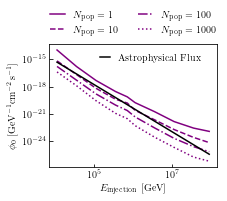

In [16]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ---------------------------------------------
# Plotting
lss = ['-', '--', '-.', ':']
for pop in range(len(pops)):
    ax1.plot(
        m_egrid[ide_scan],
        smooth(10**np.array(plot_grid_y[pop]), 1),
        label=r'$ N_\mathrm{pop}=%d $' %pops[pop], ls=lss[pop], color='purple'
    )
ax1.plot(m_egrid, astro_flux(m_egrid), ls='-', color='k',
         label=r'$\mathrm{Astrophysical\;Flux}$')
# ---------------------------------------------
# Axis options
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"$E_\mathrm{injection}\;[\mathrm{GeV}]$", fontsize=fontsize)
ax1.set_ylabel(r"$\phi_0\;[\mathrm{GeV^{-1}cm^{-2}s^{-1}}]$", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ---------------------------------------------
# Legend
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h[:pops_lens], l[:pops_lens], loc=9, bbox_to_anchor=(0.5, +1.35),
                    ncol=2, fontsize=fontsize, handlelength=1.5,
                    fancybox=True, frameon=False)
lgd2 = ax1.legend([h[pops_lens]], [l[pops_lens]], loc=9, bbox_to_anchor=(0.6, +1),
                    ncol=1, fontsize=fontsize, handlelength=h_length,
                    fancybox=True, frameon=False)
ax1.add_artist(lgd1)
# ---------------------------------------------
# Showing the image
plt.show()
# ---------------------------------------------
# Storing the image
figure.savefig(PICS + "source_limits.png",
                bbox_inches='tight', dpi=export_dpi)

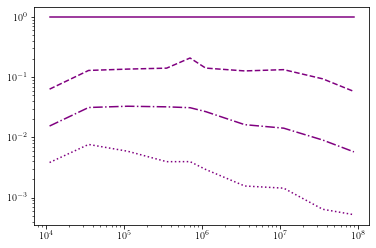

In [19]:
for pop in range(len(pops)):
    plt.loglog(
        m_egrid[ide_scan],
        smooth(10**np.array(plot_grid_y[pop]), 1) /
        smooth(10**np.array(plot_grid_y[0]), 1),
        ls=lss[pop], color='purple'
    )

In [32]:
# Converting to limits comparable to other publications
# Note the j-factor is just an estimate
j_factor = 1e23
# DM Decay model
def anni(mass):
    return 2. / mass
def dm_decay(sigmav, mass):
    return (
        1. / 4. / np.pi * sigmav / 2. / mass**2 * 1./3. * anni(mass) * j_factor
    )
# The conversion function
def solve_func(energy_grid, flux):
    limit_grid = []
    for e_id, energy in enumerate(energy_grid):
        def tmp_dm_decay(sigmav):
            return (np.log10(dm_decay(10**sigmav, energy)) - np.log10(flux[e_id]))
        limit_grid.append(
            root_scalar(tmp_dm_decay, bracket=[-26, -19], method='brentq').root
        )
    return np.array(limit_grid)

In [35]:
# Loading previous limits
icecube_limits = np.loadtxt('../data//IceCube_Limits.txt', delimiter=',')
thermal_relic = np.loadtxt('../data//Thermal_Relic.txt', delimiter=',')
antares_limits = np.loadtxt('../data//ANTARES_limits.txt', delimiter=',')
unitarity_bounds = np.loadtxt('../data/Unitarity_Bound.txt', delimiter=',')

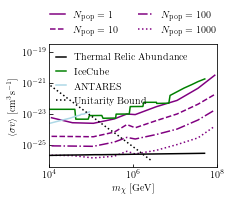

In [36]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ---------------------------------------------
# Plotting
lss = ['-', '--', '-.', ':']
for pop in range(len(pops)):
    res = smooth(solve_func(m_egrid[ide_scan],
                            10**np.array(plot_grid_y[pop])),
                 1)
    ax1.plot(
        m_egrid[ide_scan],
        10**res,
        label=r'$ N_\mathrm{pop}=%d $' %pops[pop], ls=lss[pop], color='purple'
    )
ax1.plot(thermal_relic[:, 0], thermal_relic[:, 1], color='k', ls='-',
         label=r'$\mathrm{Thermal\;Relic\;Abundance}$')
ax1.plot(icecube_limits[:, 0], icecube_limits[:, 1], color='g', ls='-',
         label=r'$\mathrm{IceCube}$')
ax1.plot(antares_limits[:, 0][:24], antares_limits[:, 1][:24],
         color='lightblue', ls='-',
         label=r'$\mathrm{ANTARES}$')
ax1.plot(unitarity_bounds[:, 0], unitarity_bounds[:, 1],
         color='k', ls=':',
         label=r'$\mathrm{Unitarity\;Bound}$')
# ---------------------------------------------
# Axis options
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"$m_\mathrm{\chi}\;[\mathrm{GeV}]$", fontsize=fontsize)
ax1.set_ylabel(r"$\langle\sigma v\rangle\;[\mathrm{cm^{3}s^{-1}}]$", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.set_xlim(1e4, 1e8)
# ---------------------------------------------
# Legend
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h[:pops_lens], l[:pops_lens], loc=9, bbox_to_anchor=(0.5, +1.35),
                    ncol=2, fontsize=fontsize, handlelength=1.5,
                    fancybox=True, frameon=False)
lgd2 = ax1.legend(h[pops_lens:], l[pops_lens:], loc=9, bbox_to_anchor=(0.43, +1),
                    ncol=1, fontsize=fontsize, handlelength=h_length,
                    fancybox=True, frameon=False)
ax1.add_artist(lgd1)
# ---------------------------------------------
# Showing the image
plt.show()
# ---------------------------------------------
# Storing the image
figure.savefig(PICS + "source_limits_dm.png",
                bbox_inches='tight', dpi=export_dpi)